# Forecasting

In this Notebook, i load the prepared data and try a Naive and ARIMA and SARIMA Model

In [2]:
# Libraries
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import pickle
from sklearn.preprocessing import StandardScaler
import itertools
import warnings
import statsmodels.api as sm

# General Function

In [3]:
# Note: H0 is: The Time Series is Non-Stationary, whic would be true if the p_value < 0.05
def run_adf(timeseries):
    """Performs Augmented Dickey-Fuller test on a given time series."""
    adf_result = adfuller(timeseries)
    p_value = adf_result[1]
    print(f'P-value is {p_value}')
    if p_value <= 0.05:
        print("The series is stationary (reject H0).")
    else:
        print("The series is non-stationary (fail to reject H0).")

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forecast(y_true, y_pred, model_name="Model"):
    """
    Evaluate forecast predictions using MSE, MAE, and R².

    Args:
        y_true (array-like): Actual values
        y_pred (array-like): Forecasted values
        model_name (str): Optional name of the model (for print output)
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"  MSE      : {mse:.2f}")
    print(f"  MAE      : {mae:.2f}")
    print(f"  R² Score : {r2:.4f}")
    
    return {"mse": mse, "mae": mae, "r2": r2}

In [5]:
# SARIMAX Evaluation function
def evaluate_sarima_forecast(model_fit, test_series, steps=None, model_name="SARIMA"):
    """
    Forecasts and evaluates a SARIMA/SARIMAX model against the test data,
    and plots the forecast vs actual values.

    Parameters:
    - model_fit: fitted SARIMAXResults object
    - test_series: pandas Series or array-like of actual test values
    - steps: number of steps to forecast (default: len(test_series))
    - model_name: optional name for display

    Returns:
    - forecast (np.array)
    """
    if steps is None:
        steps = len(test_series)

    forecast = model_fit.forecast(steps=steps)
    y_true = test_series[:steps]

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, forecast))
    mae = mean_absolute_error(y_true, forecast)
    r2 = r2_score(y_true, forecast)

    # Print metrics
    print(f"\n{model_name} Evaluation:")
    print(f"  RMSE     : {rmse:.2f}")
    print(f"  MAE      : {mae:.2f}")
    print(f"  R² Score : {r2:.4f}")

    # Plot forecast vs actual
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.index, y_true.values, label="Actual", linewidth=2)
    plt.plot(y_true.index, forecast, label="Forecast", linewidth=2, linestyle='--')
    plt.title(f"{model_name} Forecast vs Actual", fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Unit Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast



In [6]:
# Read Data
df_train = pd.read_csv('../data/new_train_cleaned.csv')
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend
0,27,804974,2013-01-08,0.0,False,2013,1,8,1,0.000000,0
1,27,804974,2013-01-09,0.0,False,2013,1,9,2,0.000000,0
2,27,804974,2013-01-10,2.0,False,2013,1,10,3,0.285714,0
3,27,804974,2013-01-11,0.0,False,2013,1,11,4,0.285714,0
4,27,804974,2013-01-12,6.0,False,2013,1,12,5,1.142857,1


In [7]:
df_train['onpromotion'] = df_train['onpromotion'].astype(int)

In [8]:


df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend
0,27,804974,2013-01-08,0.0,0,2013,1,8,1,0.000000,0
1,27,804974,2013-01-09,0.0,0,2013,1,9,2,0.000000,0
2,27,804974,2013-01-10,2.0,0,2013,1,10,3,0.285714,0
3,27,804974,2013-01-11,0.0,0,2013,1,11,4,0.285714,0
4,27,804974,2013-01-12,6.0,0,2013,1,12,5,1.142857,1


## Features Engineering (Additional)

In [9]:
# convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# From date
df_train['weekday'] = df_train['date'].dt.weekday        # 0=Monday, 6=Sunday
df_train['quarter'] = df_train['date'].dt.quarter

# Lags
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_14'] = df_train['unit_sales'].shift(14)

# Rolling Window
df_train['rolling_mean_7'] = df_train['unit_sales'].shift(1).rolling(window=7).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].shift(1).rolling(window=7).std()


In [10]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2013-01-08,0.0,0,2013,1,8,1,0.000000,0,1,1,NaN,NaN,NaN,NaN,NaN
1,27,804974,2013-01-09,0.0,0,2013,1,9,2,0.000000,0,2,1,0.0,NaN,NaN,NaN,NaN
2,27,804974,2013-01-10,2.0,0,2013,1,10,3,0.285714,0,3,1,0.0,NaN,NaN,NaN,NaN
3,27,804974,2013-01-11,0.0,0,2013,1,11,4,0.285714,0,4,1,2.0,NaN,NaN,NaN,NaN
4,27,804974,2013-01-12,6.0,0,2013,1,12,5,1.142857,1,5,1,0.0,NaN,NaN,NaN,NaN


In [11]:
df_train.dtypes

store_nbr                     int64
item_nbr                      int64
date                 datetime64[ns]
unit_sales                  float64
onpromotion                   int64
year                          int64
month                         int64
day                           int64
day_of_week                   int64
unit_sales_7d_avg           float64
weekend                       int64
weekday                       int32
quarter                       int32
lag_1                       float64
lag_7                       float64
lag_14                      float64
rolling_mean_7              float64
rolling_std_7               float64
dtype: object

In [12]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2013-01-08,0.0,0,2013,1,8,1,0.000000,0,1,1,NaN,NaN,NaN,NaN,NaN
1,27,804974,2013-01-09,0.0,0,2013,1,9,2,0.000000,0,2,1,0.0,NaN,NaN,NaN,NaN
2,27,804974,2013-01-10,2.0,0,2013,1,10,3,0.285714,0,3,1,0.0,NaN,NaN,NaN,NaN
3,27,804974,2013-01-11,0.0,0,2013,1,11,4,0.285714,0,4,1,2.0,NaN,NaN,NaN,NaN
4,27,804974,2013-01-12,6.0,0,2013,1,12,5,1.142857,1,5,1,0.0,NaN,NaN,NaN,NaN


# Split Data (train/test)

The instruction is to select only data with date < '2014-04-1' for Modelling(train)

In [13]:
df_train.dropna(inplace=True, ignore_index=True)

In [14]:
df_train.shape

(34431909, 18)

In [15]:
#test data
train = df_train[df_train['date'] < '2014-04-01']
train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
0,27,804974,2013-01-22,0.0,0,2013,1,22,1,0.714286,0,1,1,0.0,0.0,0.0,0.714286,1.889822
1,27,804974,2013-01-23,8.0,0,2013,1,23,2,1.142857,0,2,1,0.0,5.0,0.0,0.714286,1.889822
2,27,804974,2013-01-24,0.0,0,2013,1,24,3,1.142857,0,3,1,8.0,0.0,2.0,1.142857,3.023716
3,27,804974,2013-01-25,0.0,0,2013,1,25,4,1.142857,0,4,1,0.0,0.0,0.0,1.142857,3.023716
4,27,804974,2013-01-26,4.0,0,2013,1,26,5,1.714286,1,5,1,0.0,0.0,6.0,1.142857,3.023716


In [16]:
train.shape

(9176370, 18)

In [17]:
min_date = train['date'].min()
max_date = train['date'].max()
print(min_date, max_date)


2013-01-08 00:00:00 2014-03-31 00:00:00


In [18]:
# test 
test = df_train[(df_train['date'] >= '2014-01-01') & (df_train['date'] <= '2014-03-31')]
test.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,weekend,weekday,quarter,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
344,27,804974,2014-01-01,0.0,0,2014,1,1,2,0.0,0,2,1,0.0,0.0,0.0,0.0,0.0
345,27,804974,2014-01-02,0.0,0,2014,1,2,3,0.0,0,3,1,0.0,0.0,0.0,0.0,0.0
346,27,804974,2014-01-03,0.0,0,2014,1,3,4,0.0,0,4,1,0.0,0.0,0.0,0.0,0.0
347,27,804974,2014-01-04,0.0,0,2014,1,4,5,0.0,1,5,1,0.0,0.0,0.0,0.0,0.0
348,27,804974,2014-01-05,0.0,0,2014,1,5,6,0.0,1,6,1,0.0,0.0,0.0,0.0,0.0


In [19]:
min_date = test['date'].min()
max_date = test['date'].max()
print(min_date, max_date)

2014-01-01 00:00:00 2014-03-31 00:00:00


In [20]:
test.shape

(1843470, 18)

# Save train and test for other Models

In [21]:
train.to_csv('../data/train_modelling.csv')
test.to_csv('../data/test_modelling.csv')

In [21]:
test.shape

(1843470, 18)

# Base Model

## Naive
 
This model uses the value for yesterday to predict todays value for example. So let's try it.

In [22]:
last_train_value = train['unit_sales'].iloc[-1]
y_pred_naive = [last_train_value] * len(test)

# True values
y_true = test['unit_sales']



In [23]:
# Model Evaluation
evaluate_forecast(y_true, y_pred_naive, model_name="Naive Model")

Naive Model Evaluation:
  MSE      : 7.14
  MAE      : 0.22
  R² Score : -0.0067


{'mse': 7.13669724118266,
 'mae': 0.21761223507841193,
 'r2': -0.006679757276710996}

Now that there are results from a base model, we will try ARIMA and compare the results.

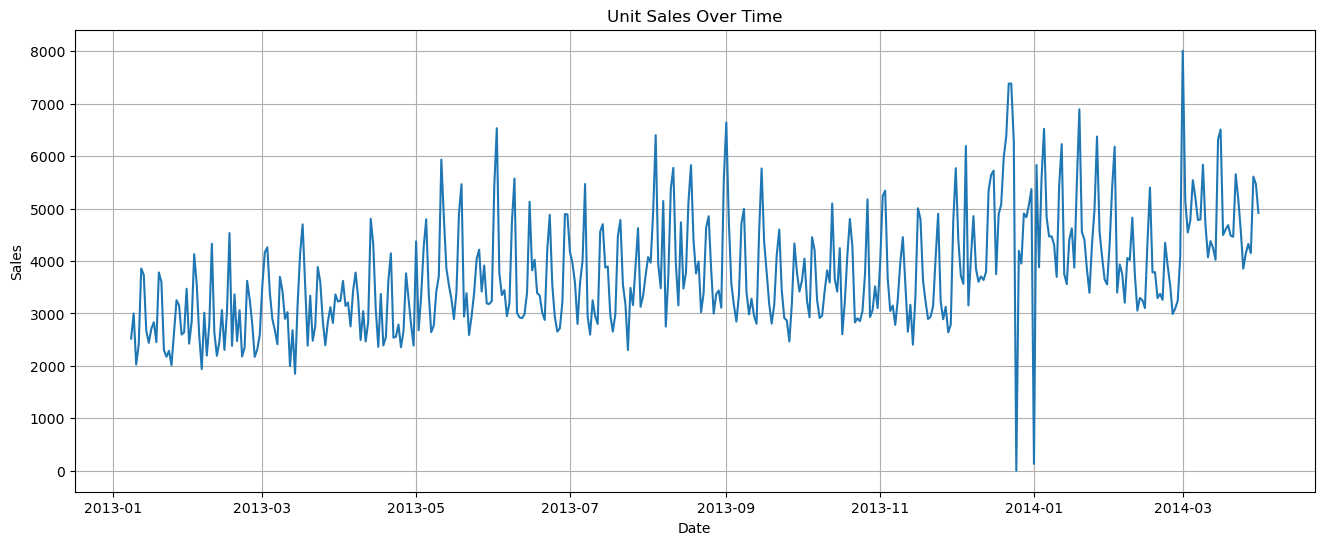

In [24]:
train_copy = train.copy()
train_series = train.groupby('date')['unit_sales'].sum()

# convert to dataframe
index = train_series.index
sales = train_series.values
train_df = pd.DataFrame({'date': index, 'unit_sales': sales})

# plot unit_sales over time
plt.figure(figsize=(16,6))
plt.plot(train_df['date'], train_df['unit_sales'])
plt.title("Unit Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

Visual inpection does not give a clear interpretation of the various components. It is necessary to use Adfuller to determine stationarity.

In [25]:
# Stationarity Check
run_adf(train_df['unit_sales'])

P-value is 0.4984539785016558
The series is non-stationary (fail to reject H0).


From Adfuller we see that the data is not stationary. We take a difference and test.

In [26]:
unit_sales_diff = train_df['unit_sales'].diff().dropna()

train_df['unit_sales_diff'] = unit_sales_diff
train_df.dropna(inplace=True, ignore_index=True)
train_df.head()

,date,unit_sales,unit_sales_diff
0,2013-01-09,3000.0,480.0
1,2013-01-10,2026.0,-974.0
2,2013-01-11,2401.0,375.0
3,2013-01-12,3856.0,1455.0
4,2013-01-13,3737.0,-119.0


Test for stationarity again

In [27]:
# Stationarity Check
run_adf(train_df['unit_sales_diff'])

P-value is 8.8632130118736e-22
The series is stationary (reject H0).


Now the dataset is staionary after taking the difference once

# ACF & PACF Plots

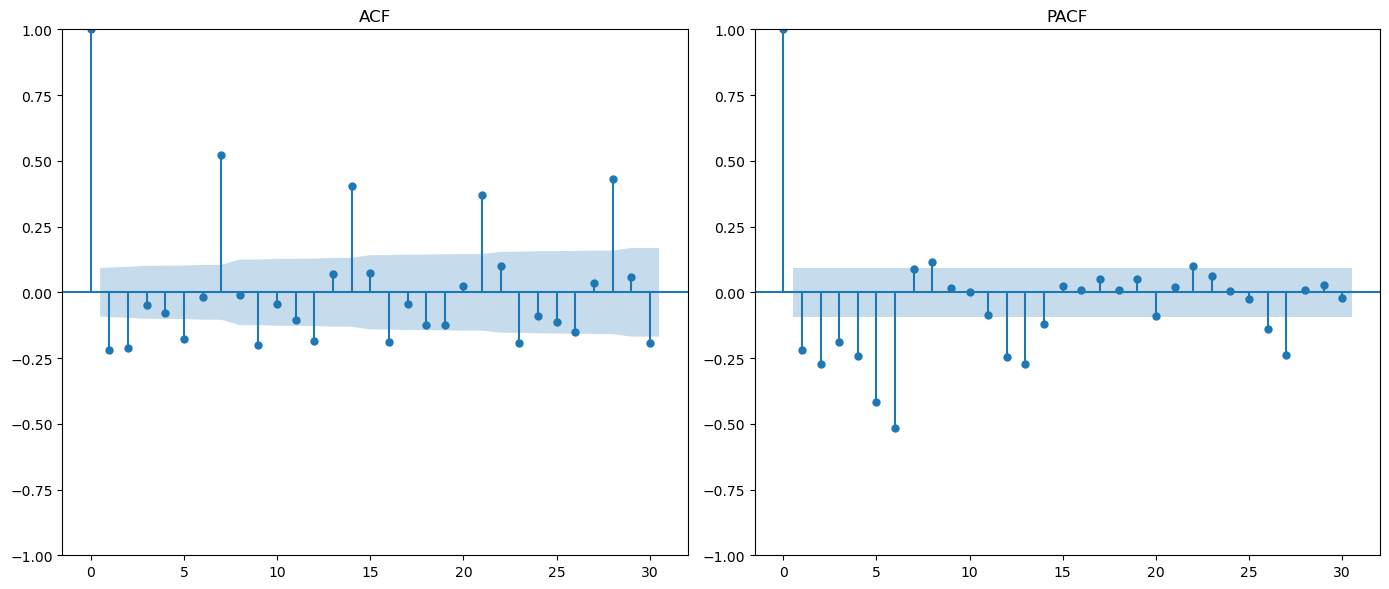

In [28]:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(train_df['unit_sales_diff'], ax=plt.gca(), lags=30)
plt.title("ACF")

plt.subplot(1, 2, 2)
plot_pacf(train_df['unit_sales_diff'], ax=plt.gca(), lags=30)
plt.title("PACF")

plt.tight_layout()
plt.show()

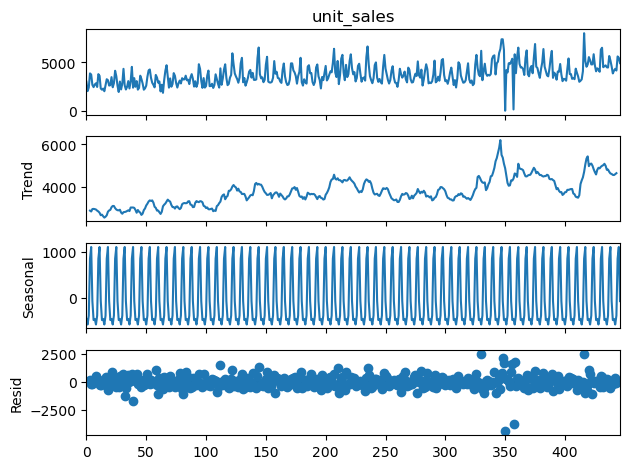

In [29]:
# Decompoase the data
# Assume df['sales'] is your time series and has a datetime index
result = seasonal_decompose(train_df['unit_sales'], model='additive', period=7)

# Clean single plot (no duplicates)
result.plot()
plt.tight_layout()
plt.savefig("decomposition.png")
plt.show()


Since the data shows trend and very strong seasonality, the best model would be SAMIRA which i try next.


# Grid Search For SARIMAX

In [30]:
warnings.filterwarnings("ignore")

# Use your time series
y = train_df['unit_sales']  # Make sure df has a datetime index

# Define the parameter ranges
p = d = q = range(0, 3)     # try 0, 1, 2
P = D = Q = range(0, 2)     # simpler for seasonal terms
s = 7  # Weekly seasonality

In [31]:
# Variables:
p = range(0, 3)  # Try p values: 0, 1, 2
q = range(0, 3)  # Try q values: 0, 1, 2

# Create all combinations
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = list(itertools.product(P, [1], Q, [s]))

best_aic = np.inf
best_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)

            print(f"SARIMAX{param}x{seasonal_param} - AIC:{results.aic:.2f}")

        except Exception as e:
            continue

print("\nBest model:")
print(f"SARIMAX{best_params[0]}x{best_params[1]} - AIC:{best_aic:.2f}")


SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:7357.82
SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:7078.48
SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:7197.73
SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:7065.36
SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:7198.90
SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:6855.22
SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:6996.32
SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:6856.20
SARIMAX(0, 1, 2)x(0, 1, 0, 7) - AIC:7141.26
SARIMAX(0, 1, 2)x(0, 1, 1, 7) - AIC:6841.25
SARIMAX(0, 1, 2)x(1, 1, 0, 7) - AIC:7008.07
SARIMAX(0, 1, 2)x(1, 1, 1, 7) - AIC:6841.02
SARIMAX(1, 1, 0)x(0, 1, 0, 7) - AIC:7268.45
SARIMAX(1, 1, 0)x(0, 1, 1, 7) - AIC:6968.42
SARIMAX(1, 1, 0)x(1, 1, 0, 7) - AIC:7075.66
SARIMAX(1, 1, 0)x(1, 1, 1, 7) - AIC:6961.99
SARIMAX(1, 1, 1)x(0, 1, 0, 7) - AIC:7155.15
SARIMAX(1, 1, 1)x(0, 1, 1, 7) - AIC:6856.08
SARIMAX(1, 1, 1)x(1, 1, 0, 7) - AIC:6966.60
SARIMAX(1, 1, 1)x(1, 1, 1, 7) - AIC:6855.43
SARIMAX(1, 1, 2)x(0, 1, 0, 7) - AIC:7172.75
SARIMAX(1, 1, 2)x(0, 1, 1, 7) - AIC:6836.92
SARIMAX(1, 1, 2)x(1, 1, 0, 7) - 

## Refit Model with with train set

In [32]:
model = sm.tsa.statespace.SARIMAX(
    train_df['unit_sales'],
    order=(1, 1, 2),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          unit_sales   No. Observations:                  447
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -3411.459
Date:                             Thu, 19 Jun 2025   AIC                           6834.918
Time:                                     01:18:25   BIC                           6859.287
Sample:                                          0   HQIC                          6844.541
                                             - 447                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7242      0.080      9.095      0.000       0.568       0.880
ma.L1         -3.0522      

## Plot of result diagnostics

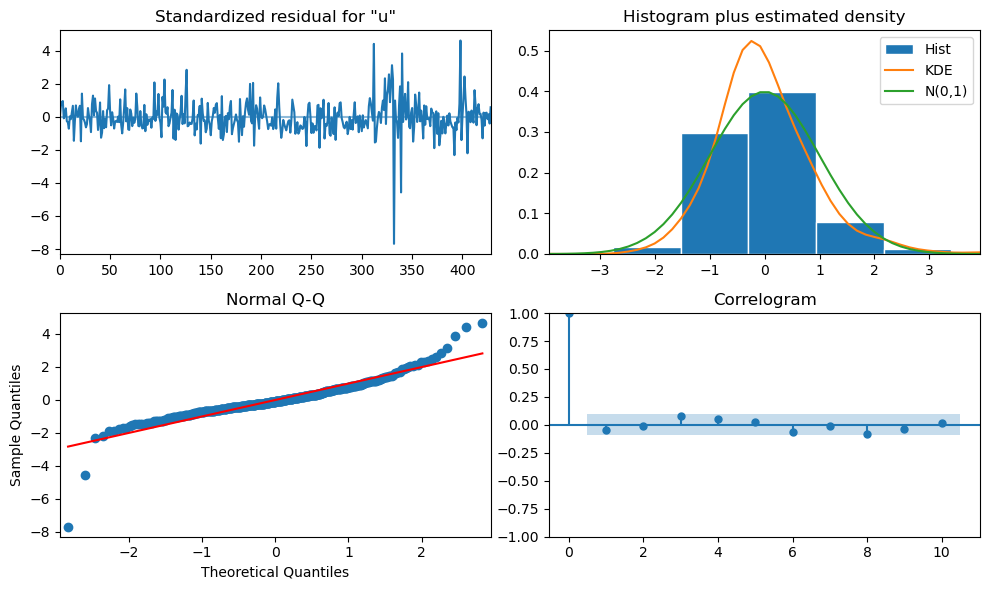

In [33]:
results.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

# Prediction on Test

In [34]:
# Prepare test_df
test_copy = test.copy()
test_series = test.groupby('date')['unit_sales'].sum()

# convert to dataframe
index = test_series.index
sales = test_series.values
test_df = pd.DataFrame({'date': index, 'unit_sales': sales})

In [35]:
# Forecast same length as test set
n_steps = len(test_df)
forecast = results.forecast(steps=n_steps)

# True values
y_true = test_df['unit_sales'].values

evaluate_forecast(y_true, forecast, 'SARIMAX')



SARIMAX Evaluation:
  MSE      : 1378970.49
  MAE      : 905.28
  R² Score : -0.1829


{'mse': 1378970.491780287,
 'mae': 905.2769625522889,
 'r2': -0.18287336239132768}

## Model Evaluation 


SARIMA Evaluation:
  RMSE     : 1174.30
  MAE      : 905.28
  R² Score : -0.1829


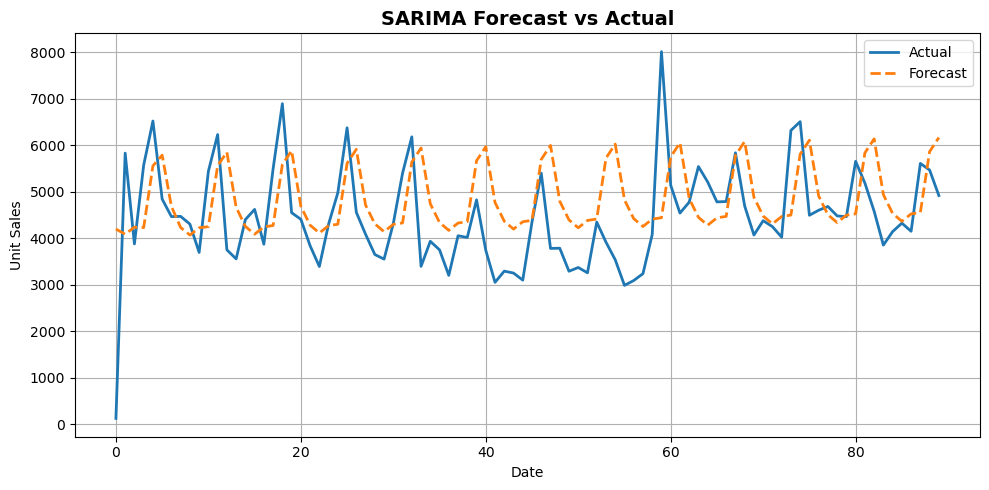

447    4198.497846
448    4087.257374
449    4239.112208
450    4230.702576
451    5556.791269
          ...     
532    4366.248529
533    4524.205053
534    4554.739015
535    5862.753892
536    6165.074134
Name: predicted_mean, Length: 90, dtype: float64

In [36]:
evaluate_sarima_forecast(results, test_df['unit_sales'], steps=None, model_name="SARIMA")